# <center>${\textbf{position and Lap Time in Qualifying Session}}$</center>

${\textbf{Overview}}$

A Formula One season consists of a series of races, known as Grands Prix, which take place worldwide on purpose-built circuits and on public roads. <br>
A single competition takes place over three days, day one is a practice session ,the second day is the qualification round in which racers compete against time in order to obtain an advantageous position during  the third day which is the final race where drivers race against each other .<br>
Most importantly for our case a  qualifying session is held before each race to determine the order cars will be lined up in at the start of the race, with the fastest qualifier starting at the front and the slowest at the back.<br>
Currently, the first qualifying period (Q1) is eighteen minutes long, with all twenty cars competing.<br>
At the end of Q1, the five slowest drivers are eliminated from further qualification rounds, and fill positions sixteen to twenty on the grid based on their fastest lap time. Any driver attempting to set a qualifying time when the period ends is permitted to finish his lap, though no new laps may be started once the chequered flag is shown. <br>
After a short break, the second period (Q2) begins, with fifteen cars on the circuit.
<br> At the end of Q2, the five slowest drivers are once again eliminated, filling grid positions eleven to fifteen. Finally, the third qualifying period (Q3) features the ten fastest drivers from the second period. 
<br>The drivers are issued a new set of soft tyres and have twelve minutes to set a qualifying time, which will determine the top ten positions on the grid. The driver who sets the fastest qualifying time is said to be on pole position, the grid position that offers the best physical position from which to start the race.<br>

${\textbf{Importance of Data}}$

The insight analysis drills down to all information on the Formula 1 races, drivers, constructors, qualifying, circuits, lap times, pit stops, championships from 1950 till the latest 2021 season.<br>
With the amount of data being captured, analyzed and used to design, build and drive the Formula 1 cars is astounding. It is a global sport being followed by millions of people worldwide and it is very fascinating to see drivers pushing their limit in these vehicles to become the fastest racers in the world!<br>

${\textbf{Import Libraries}}$

In [1]:
%matplotlib inline
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pip
import geopandas
import altair as alt
from descartes.patch import PolygonPatch
from datetime import datetime
from apyori import apriori 
import plotly.express as px
from sklearn.svm import SVC
import warnings
warnings.simplefilter("ignore")

# importing ML libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import tree
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.metrics import  roc_auc_score

## ${\textbf{Part 1 - First Steps  }}$

>${\textbf{Connect with Database}}$

Previously on the integration Phase we have used Talend Open Studio for Intergration Services linkes with a PostgresSQL .<br>So now it's only logical that we connect python with the postgres Database in order to retrieve our dimensional data

In [2]:
def DbConnect():
    conn = psycopg2.connect(host="localhost",database="FormulaOne",port=5432,user='postgres',password='root')
    return conn

>${\textbf{Get data from QualifyingFact and related tables}}$

In [3]:
weather = pd.read_sql('select * from "WeatherDim"', con=DbConnect())
date= pd.read_sql('select * from "DateTimeDim"', con=DbConnect())
circuit = pd.read_sql('select * from "CircuitDim"', con=DbConnect())
races= pd.read_sql('select * from "RaceDim"', con=DbConnect())
driver= pd.read_sql('select * from "DriverDim"', con=DbConnect())
constructor= pd.read_sql('select * from "ConstructorsDim"', con=DbConnect())
qualifyingFact= pd.read_sql('select * from "QualifyingFact"', con=DbConnect())

>${\textbf{Merging Data to a single DataFrame }}$

Renaming certain columns is essential for the merging 

In [4]:
races.rename(columns = {'datetime_fk':'dateId'}, inplace = True)
races.rename(columns = {'weather_fk':'weatherID'}, inplace = True)
races.rename(columns = {'circuit_fk':'CircuitId'}, inplace = True)
qualifyingFact.rename(columns = {'race_fk':'raceId'}, inplace = True)
qualifyingFact.rename(columns = {'driver_fk':'DriverID'}, inplace = True)
qualifyingFact.rename(columns = {'constructor_fk':'constructorId'}, inplace = True)

In [5]:
df1 = pd.merge(races,date, on='dateId', how='inner')
df2 = pd.merge(df1,circuit, on='CircuitId', how='inner')
df3 = pd.merge(df2,weather, on='weatherID', how='inner')
df4 = pd.merge(qualifyingFact,df3, on='raceId', how='inner')
df5 = pd.merge(df4,driver, on='DriverID', how='inner')
Fact = pd.merge(df5,constructor, on='constructorId', how='inner')

## ${\textbf{Part 2 - Exploratory Data Analysis  }}$

> ${\textbf{Renaming columns }}$

In [6]:
Fact.rename(columns = {'name_x':'nameGP','name_y':'nameCircuit','Nationality':'driverNationality'}, inplace = True)

> ${\textbf{Converting Date of birth to AGE}}$

The date of birth by itself can't be a great axis that we could retrieve and explain our  data from it so we opted for a conversion from date type to integer

In [7]:
Fact['Dob']=pd.to_datetime(Fact['Dob'])
date=datetime.today()-Fact['Dob']
Fact['age']=round(date.dt.days/365)

> ${\textbf{Concatenating firstname and lastname }}$

In [8]:
Fact["nameDriver"]=Fact["ForeName"]+" "+Fact["SurName"]

> ${\textbf{ Converting DateTime.Time Format to Milliseconds for a better overlook }}$

Various methods such as aggregation or summation can't work with dateTime.Time types , also previously we noticed a great deal of null data with is explained in the introduction so nulls will be zeros and time will be converted to milliseconds

In [9]:
Fact['q1_sec']=0
for i in range(0,len(Fact)):
    t=Fact['q1'].iat[i]
    if t is None:
        Fact['q1_sec'].iat[i] = int(0)
    else:
        Fact['q1_sec'].iat[i] = int(t.hour*3600000000+t.minute*60000000+t.second*1000000+t.microsecond)

In [10]:
Fact['q2_sec']=0
for i in range(0,len(Fact)):
    t=Fact['q2'].iat[i]
    if t is None:
        Fact['q2_sec'].iat[i] = int(0)
    else:
        Fact['q2_sec'].iat[i] = int(t.hour*3600000000+t.minute*60000000+t.second*1000000+t.microsecond)

In [11]:
Fact['q3_sec']=0
for i in range(0,len(Fact)):
    t=Fact['q3'].iat[i]
    if t is None:
        Fact['q3_sec'].iat[i] = int(0)
    else:
        Fact['q3_sec'].iat[i] = int(t.hour*3600000000+t.minute*60000000+t.second*1000000+t.microsecond)

> ${\textbf{Dropping unaffectful columns}}$

In [12]:
Fact.drop(columns=['raceId',
                   'DriverID',
                   'constructorId',
                   'CircuitId',
                   'dateId',
                   'weatherID',
                   'constructorRef',
                   'DriverRef',
                   'circuitRef',
                   'ForeName',
                   'SurName',
                   'Dob',
                   'number',
                   'time',
                   'Number',
                    'day',
                   'car',
                   'month',
                   'Altitude',
                   'location',
                   'points',
                   'img',
                   'weather',
                   'q1',
                   'q2',
                   'q3'],axis=1,inplace=True)

> ${\textbf{Columns }}$

In [13]:
Fact.columns

Index(['position', 'round', 'nameGP', 'date', 'year', 'nameCircuit',
       'latitude', 'longitude', 'country', 'Code', 'driverNationality',
       'constructorName', 'constructorNationality', 'age', 'nameDriver',
       'q1_sec', 'q2_sec', 'q3_sec'],
      dtype='object')

> ${\textbf{Data types and shape  }}$

In [14]:
Fact.info()
Fact.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4759 entries, 0 to 4758
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   position                4759 non-null   int64  
 1   round                   4759 non-null   int64  
 2   nameGP                  4759 non-null   object 
 3   date                    4759 non-null   object 
 4   year                    4759 non-null   int64  
 5   nameCircuit             4759 non-null   object 
 6   latitude                4759 non-null   float64
 7   longitude               4759 non-null   float64
 8   country                 4759 non-null   object 
 9   Code                    4759 non-null   object 
 10  driverNationality       4759 non-null   object 
 11  constructorName         4759 non-null   object 
 12  constructorNationality  4759 non-null   object 
 13  age                     4759 non-null   float64
 14  nameDriver              4759 non-null   

(4759, 18)

Overall we have 18 columns and 4759 rows

> ${\textbf{Head and tails }}$

In [15]:
Fact.head()

,position,round,nameGP,date,year,nameCircuit,latitude,longitude,country,Code,driverNationality,constructorName,constructorNationality,age,nameDriver,q1_sec,q2_sec,q3_sec
0,1,1,Australian Grand Prix,2008-03-16,2008,Albert Park Grand Prix Circuit,-37.84970,144.96800,Australia,HAM,British,McLaren,British,37.0,Lewis Hamilton,86572000,85187000,86714000
1,4,2,Malaysian Grand Prix,2008-03-23,2008,Sepang International Circuit,2.76083,101.73800,Malaysia,HAM,British,McLaren,British,37.0,Lewis Hamilton,95392000,94627000,96709000
2,3,3,Bahrain Grand Prix,2008-04-06,2008,Bahrain International Circuit,26.03250,50.51060,Bahrain,HAM,British,McLaren,British,37.0,Lewis Hamilton,92750000,91922000,93292000
3,5,4,Spanish Grand Prix,2008-04-27,2008,Circuit de Barcelona-Catalunya,41.57000,2.26111,Spain,HAM,British,McLaren,British,37.0,Lewis Hamilton,81366000,80825000,82096000
4,3,5,Turkish Grand Prix,2008-05-11,2008,Istanbul Park,40.95170,29.40500,Turkey,HAM,British,McLaren,British,37.0,Lewis Hamilton,86192000,86477000,87923000


In [16]:
Fact.tail()

,position,round,nameGP,date,year,nameCircuit,latitude,longitude,country,Code,driverNationality,constructorName,constructorNationality,age,nameDriver,q1_sec,q2_sec,q3_sec
4754,21,17,Japanese Grand Prix,2016-10-09,2016,Suzuka Circuit,34.8431,136.5410,Japan,OCO,French,Manor Marussia,British,26.0,Esteban Ocon,93353000,0,0
4755,22,18,United States Grand Prix,2016-10-23,2016,Circuit of the Americas,30.1328,-97.6411,USA,OCO,French,Manor Marussia,British,26.0,Esteban Ocon,98806000,0,0
4756,20,19,Mexican Grand Prix,2016-10-30,2016,Autódromo Hermanos Rodríguez,19.4042,-99.0907,Mexico,OCO,French,Manor Marussia,British,26.0,Esteban Ocon,81881000,0,0
4757,20,20,Brazilian Grand Prix,2016-11-13,2016,Autódromo José Carlos Pace,-23.7036,-46.6997,Brazil,OCO,French,Manor Marussia,British,26.0,Esteban Ocon,73432000,0,0
4758,20,21,Abu Dhabi Grand Prix,2016-11-27,2016,Yas Marina Circuit,24.4672,54.6031,UAE,OCO,French,Manor Marussia,British,26.0,Esteban Ocon,102286000,0,0


> ${\textbf{checking of null values }}$

As previously explained we have anticipated the nulls and fixed them in the preporcessing phase

In [17]:
Fact.isna().sum()

position                  0
round                     0
nameGP                    0
date                      0
year                      0
nameCircuit               0
latitude                  0
longitude                 0
country                   0
Code                      0
driverNationality         0
constructorName           0
constructorNationality    0
age                       0
nameDriver                0
q1_sec                    0
q2_sec                    0
q3_sec                    0
dtype: int64

> ${\textbf{Heatmap }}$

A heatmap contains values representing various shades of the same colour for each value to be plotted. Usually the darker shades of the chart represent higher values than the lighter shade. For a very different value a completely different colour can also be used. <br>
Each square shows the correlation between the variables on each axis. Correlation ranges from -1 to +1. Values closer to zero means there is no linear trend between the two variables. The close to 1 the correlation is the more positively correlated they are; that is as one increases so does the other and the closer to 1 the stronger this relationship is. A correlation closer to -1 is similar, but instead of both increasing one variable will decrease as the other increases. The diagonals are all 1/dark green because those squares are correlating each variable to itself (so it's a perfect correlation). For the rest the larger the number and darker the color the higher the correlation between the two variables. The plot is also symmetrical about the diagonal since the same two variables are being paired together in those squares.

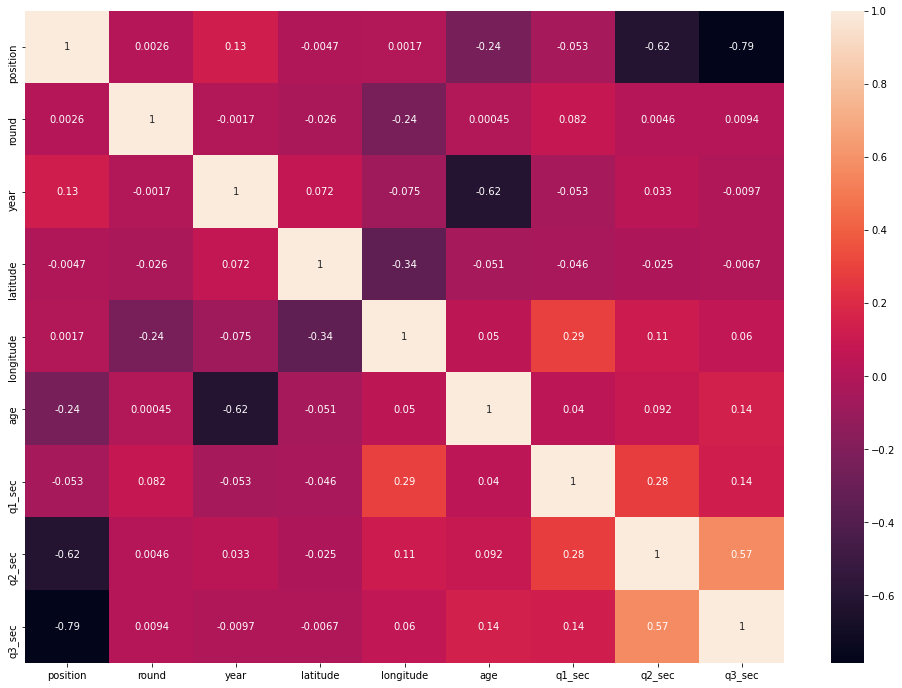

In [18]:
plt.figure(figsize=(17,12))
sns.heatmap(Fact.corr(),annot=True)
plt.show()

Q3,Q2,Q1 and position have a very high correlation values

## ${\textbf{Part 3 - Data Analysis and Predictive Models  }}$

>${\textbf{Association Rules  }}$

Association rules are "if-then" statements, that help to show the probability of relationships between data items, within large data sets in various types of database

>>${\textbf{Select our features }}$

Our goal is to associate position with driver codes so that we can have an idea of the trend

In [19]:
selected_columns = Fact[["position","Code"]]
df = selected_columns.copy()
df

,position,Code
0,1,HAM
1,4,HAM
2,3,HAM
3,5,HAM
4,3,HAM
...,...,...
4754,21,OCO
4755,22,OCO
4756,20,OCO
4757,20,OCO


>>${\textbf{Convert DataFrame to array for a better flow }}$

In [20]:
records = []
for i in range(0, len(df)):
    records.append([str(df.values[i,j]) for j in range(0, 2)])

>>${\textbf{Convert position to boolean value if achieved }}$

In [21]:
enc = TransactionEncoder()
enc_ary = enc.fit(records).transform(records)
df = pd.DataFrame(enc_ary, columns=enc.columns_)

>>${\textbf{ Use of the Apriori algorithm }}$

The Apriori algorithm uses three matrices to find the best association rules from a dataset, making its approach on datasets successful

In [22]:
frequent_itemsets = apriori(df, min_support=0.005, use_colnames=True)

>>${\textbf{ Use of the Association Rules }}$

In [23]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)

>>${\textbf{Association Rules Results }}$

In [24]:
selected_columns = rules[["antecedents","consequents","confidence"]]
rules = selected_columns.copy()
rules.sort_values(by="confidence",ascending=False).tail(15)

,antecedents,consequents,confidence
43,(6),(MAS),0.098814
47,(6),(RIC),0.098814
31,(HAM),(4),0.098182
30,(4),(HAM),0.098182
42,(MAS),(6),0.097276
18,(3),(ALO),0.096654
13,(2),(RAI),0.095420
28,(4),(ALO),0.094545
44,(RAI),(6),0.093548
32,(MAS),(4),0.093385


In [26]:
# Function to convert rules to coordinates.
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

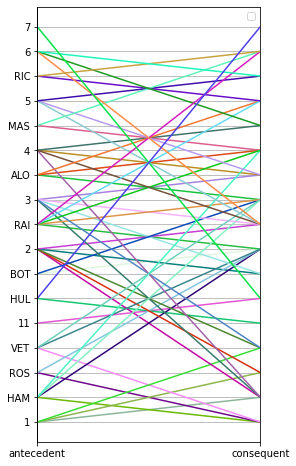

In [27]:
from pandas.plotting import parallel_coordinates


# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()

As shown in the dataframe above we can detect various trends and we can associate drivers to positions.In fact those informations are highly valuable for sponsors to detect potential winners in Qualification Session

>>${\textbf{ Conversion to xlsx File }}$

In [25]:
rules.to_excel(r'rules.xlsx')

>${\textbf{ Classification }}$

Classification in supervised Machine Learning (ML) is the process of predicting the class or category of data based on predefined classes of data that have been 'labeled'. Labeled data is data that has already been classified.

>>${\textbf{ Data encoding }}$

In [26]:
# selected_columns = Fact[["q1_sec","q2_sec","q3_sec","position","nameDriver"]]
# df = selected_columns.copy()
le = LabelEncoder()
# encoding categorical columns

for i in Fact:
    Fact[i] = le.fit_transform(Fact[i])

>>${\textbf{ Feature engineering }}$

Our classified data is the name of the driver 

In [27]:
x = Fact.drop(["nameDriver","position","round","date","year","latitude","longitude","country","constructorName","constructorNationality","nameGP","nameCircuit"], axis=1) #axis= 1 : supprimer une colonne/ axis= 0 (default value= supprimer une ligne)
y = Fact["nameDriver"]
x.columns

Index(['Code', 'driverNationality', 'age', 'q1_sec', 'q2_sec', 'q3_sec'], dtype='object')

>>${\textbf{ Selecting features to train the model }}$

According to the general rules we have split our data to test(0.3) and train(0.8) 

In [28]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42)

>>${\textbf{  classification ML algorithms }}$

In [29]:
lr = LogisticRegression(solver='sag')
knn = KNeighborsClassifier()
sgd = SGDClassifier()

In [30]:
li = [lr,sgd,knn]
d = {}
for i in li:
    i.fit(xtrain,ytrain)
    ypred = i.predict(xtest)
    print(i,"Accuracy :",accuracy_score(ypred,ytest)*100)
    d.update({str(i):i.score(xtest,ytest)*100})

LogisticRegression(solver='sag') Accuracy : 20.868347338935575
SGDClassifier() Accuracy : 7.913165266106442
KNeighborsClassifier() Accuracy : 6.582633053221289


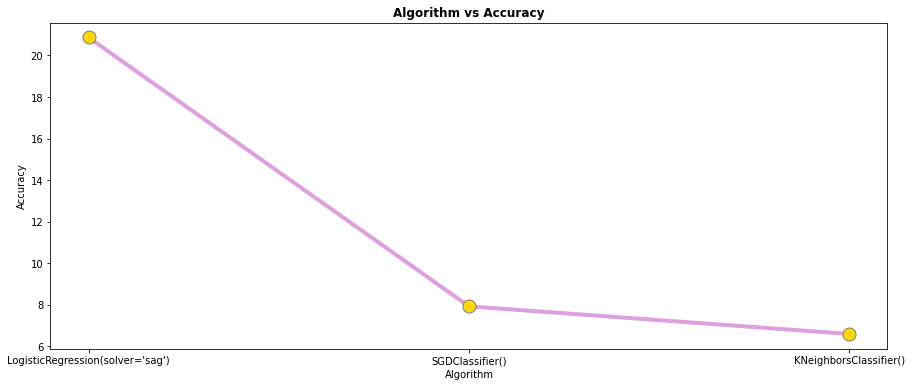

In [31]:
plt.figure(figsize=(15, 6))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(d.keys(),d.values(),marker='o',color='plum',linewidth=4,markersize=13,
         markerfacecolor='gold',markeredgecolor='slategray')
plt.show()

>>${\textbf{ Fit scaling on training data using MinMaxScaler }}$

In [32]:
norm = MinMaxScaler().fit(xtrain)
# transform training data
X_train_norm = norm.transform(xtrain)
# transform testing data
X_test_norm = norm.transform(xtest)

In [33]:
li = [lr,sgd,knn]
di = {}
for i in li:
    i.fit(X_train_norm,ytrain)
    ypred = i.predict(X_test_norm)
    print(i,":",accuracy_score(ypred,ytest)*100)
    di.update({str(i):i.score(X_test_norm,ytest)*100})

LogisticRegression(solver='sag') : 78.43137254901961
SGDClassifier() : 66.59663865546219
KNeighborsClassifier() : 93.76750700280112


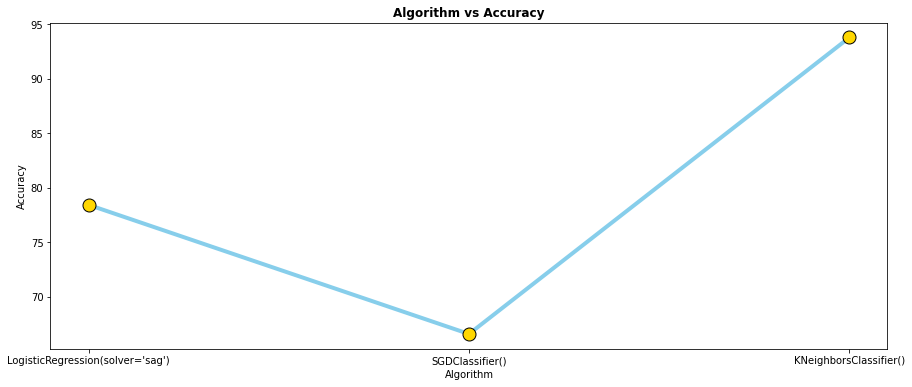

In [34]:
plt.figure(figsize=(15, 6))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(di.keys(),di.values(),marker='o',color='skyblue',linewidth=4,markersize=13,
         markerfacecolor='gold',markeredgecolor='black')
plt.show()

>>${\textbf{ Fit scaling on training data using StandardScaler }}$

In [35]:
# fit scaler on training data
std = StandardScaler().fit(xtrain)
# transform train data
x_train_std = std.transform(xtrain)
# transform test data
x_test_std = std.transform(xtest)

In [36]:
li = [lr,sgd,knn]
dic = {}
for i in li:
    i.fit(x_train_std,ytrain)
    ypred = i.predict(x_test_std)
    print(i,":",accuracy_score(ypred,ytest)*100)
    dic.update({str(i):i.score(x_test_std,ytest)*100})

LogisticRegression(solver='sag') : 93.8375350140056
SGDClassifier() : 71.56862745098039
KNeighborsClassifier() : 94.53781512605042


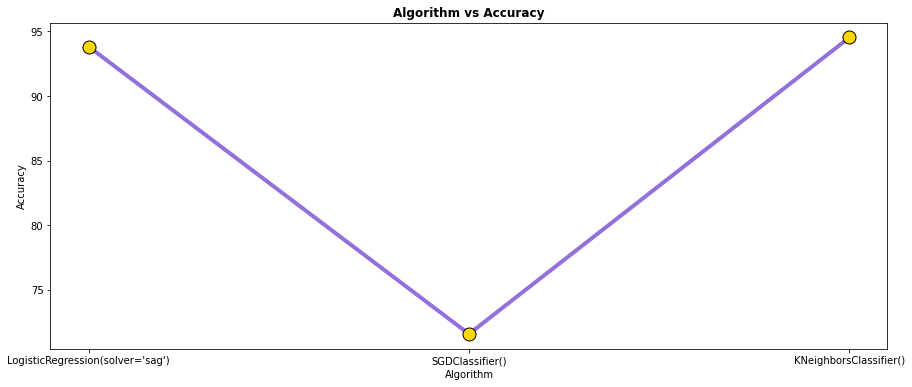

In [37]:
plt.figure(figsize=(15, 6))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(dic.keys(),dic.values(),marker='o',color='mediumpurple',linewidth=4,markersize=13,
         markerfacecolor='gold',markeredgecolor='black')
plt.show()

>>${\textbf{ Fit scaling on training data using RobustScaler }}$

In [38]:
# fit scaler on train data
scaler = RobustScaler().fit(xtrain)
# transform train data
xtrain_scaled = scaler.transform(xtrain)
# transform test data
xtest_scaled = scaler.transform(xtest)

In [39]:
li = [lr,sgd,knn]
dics = {}
for i in li:
    i.fit(xtrain_scaled,ytrain)
    ypred = i.predict(xtest_scaled)
    print(i,":",accuracy_score(ypred,ytest)*100)
    dics.update({str(i):i.score(xtest_scaled,ytest)*100})

LogisticRegression(solver='sag') : 89.84593837535014
SGDClassifier() : 71.42857142857143
KNeighborsClassifier() : 95.7983193277311


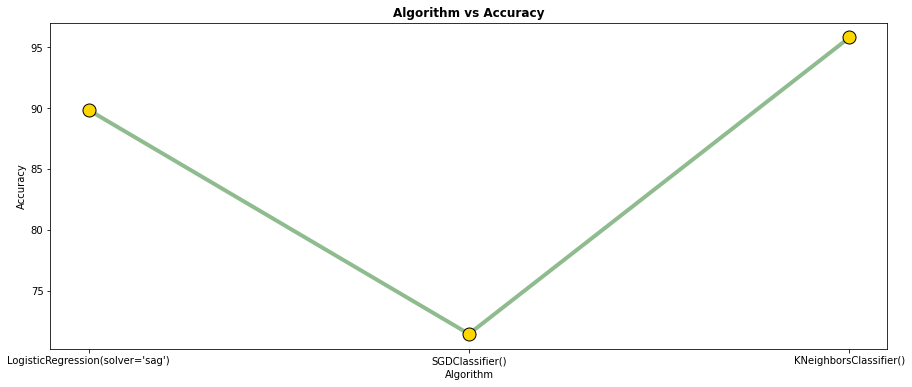

In [40]:
plt.figure(figsize=(15, 6))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(dics.keys(),dics.values(),marker='o',color='darkseagreen',linewidth=4,markersize=13,
         markerfacecolor='gold',markeredgecolor='black')
plt.show()

>>${\textbf{ Classification Report of Logistic Regression }}$

In [41]:
ypred = lr.predict(xtest_scaled)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        40
           1       1.00      1.00      1.00         9
           4       0.70      0.41      0.52        17
           5       0.00      0.00      0.00         9
           6       0.87      0.97      0.92        35
           7       0.71      0.80      0.75        15
           8       0.92      1.00      0.96        56
           9       0.91      1.00      0.96        32
          10       0.82      0.93      0.87        15
          11       1.00      1.00      1.00        27
          12       1.00      1.00      1.00        73
          13       0.38      0.30      0.33        10
          14       1.00      1.00      1.00        96
          15       0.00      0.00      0.00        12
          17       0.88      0.39      0.54        18
          18       1.00      1.00      1.00        88
          19       0.00      0.00      0.00        10
          20       0.80    

>>${\textbf{Confusion Matrix and Accuracy Score}}$

[[37  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ... 37  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  0]]


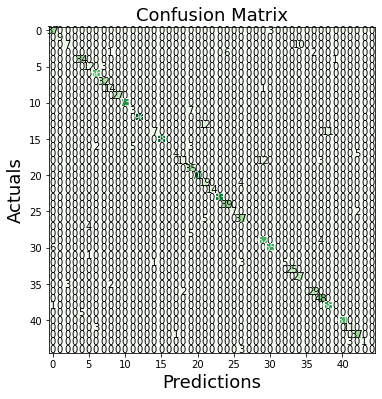

In [42]:
cm7 = confusion_matrix(ytest, ypred)
print(cm7)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm7, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [43]:
logreg=accuracy_score(ytest,ypred)
logreg


0.8984593837535014

In [46]:
test={'Code':['11'],'driverNationality':['24'],'age':['30'],'q1_sec':['93353000'],'q2_sec':['93353000'],'q3_sec':['93353000']}
df=pd.DataFrame(test)
pred = lr.predict(df)
print(pred)

[33]
